*** 
<center><img src="https://cdn-icons-png.flaticon.com/512/9196/9196974.png" width=80 height=80 /></center>
<h1><center>Loan Approval Prediction</center></h1>

**About the Dataset:**

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Loan Approval Prediction dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.



**Goal:**

The goal for this competition is to predict whether an applicant is approved for a loan.

**Evaluation**

Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets.

***

In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [47]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import xgboost as xgb

# Import data

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv", index_col=0)
test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv", index_col=0)

# Gather basic Information

In [3]:
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
print(f'Number of rows: {train.shape[0]} \nNumber of cols: {train.shape[1]}')

print('\n')

negative = train['loan_status'][train['loan_status'] == 0].count()
positive = train['loan_status'][train['loan_status'] == 1].count()

print(f'Negative: {negative}\nPositve: {positive} \n%Positive: {positive/(positive+negative):.2f}')

Number of rows: 58645 
Number of cols: 12


Negative: 50295
Positve: 8350 
%Positive: 0.14


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [6]:
train['person_income'] = train['person_income'].astype(float)
train['loan_amnt'] = train['loan_amnt'].astype(float)

In [7]:
# Remove person age and person employment lenght > 100

train_subset = train[(train['person_age'] < 100)]

train_subset = train_subset[train_subset['person_emp_length'] < 100]

In [8]:
train_subset.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
person_age,58642.0,27.55,6.02,20.00,23.00,26.00,30.00,84.00
person_income,58642.0,64044.53,37928.22,4200.00,42000.00,58000.00,75600.00,1900000.00
person_emp_length,58642.0,4.70,3.90,0.00,2.00,4.00,7.00,41.00
loan_amnt,58642.0,9217.15,5563.38,500.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,58642.0,10.68,3.03,5.42,7.88,10.75,12.99,23.22
loan_percent_income,58642.0,0.16,0.09,0.00,0.09,0.14,0.21,0.83
cb_person_cred_hist_length,58642.0,5.81,4.03,2.00,3.00,4.00,8.00,30.00
loan_status,58642.0,0.14,0.35,0.00,0.00,0.00,0.00,1.00


In [9]:
train_subset.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [10]:
train_subset[train_subset.duplicated()]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,


# Prepare the data for data viz

In [11]:
train_viz = train_subset.copy()

In [12]:
# create an age group
train_viz['age_group'] = ['<=30' if val <= 30 else '31 - 40'
                          if val <= 40 else '41 - 50'
                          if val <= 50 else '51 - 60'
                          if val <=60 else '> 60'
                          for val in train_viz['person_age']]

In [13]:
# mapping grade 
grade_num = {'A':1, 'B':2, 'C':3, 'D':4,'E':5,'F':6, 'G':7}

train_viz['grade_num'] = train_viz['loan_grade'].map(grade_num)

In [14]:
train_viz['person_home_ownership'] = train_viz['person_home_ownership'].str.title()
train_viz['loan_intent'] = train_viz['loan_intent'].str.title()

In [15]:
train_viz['cb_person_default_on_file'] = train_viz['cb_person_default_on_file'].apply(lambda cap: 'No' if cap == 'N' else 'Yes')

In [16]:
train_viz['loan_status'] = train_viz['loan_status'].apply(lambda x: 'No' if x == 0 else 'Yes')

In [17]:
categorical_var = list(train_viz.select_dtypes('object').columns)
continous_var = list(train_viz.select_dtypes('float64').columns)
discrete_var = list(train_viz.select_dtypes('int').columns)

# Exploratory Data Analysis

### Check class %

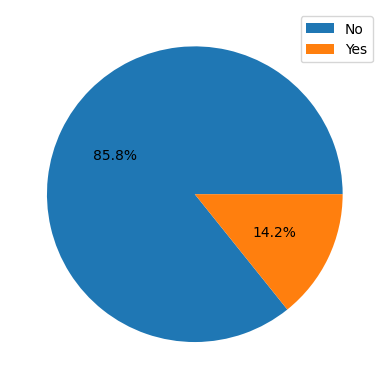

In [18]:
plt.pie(train_viz['loan_status'].value_counts(),
               autopct='%.1f%%')
plt.legend(train_viz['loan_status'].unique());

### Distribution Categorical Variables

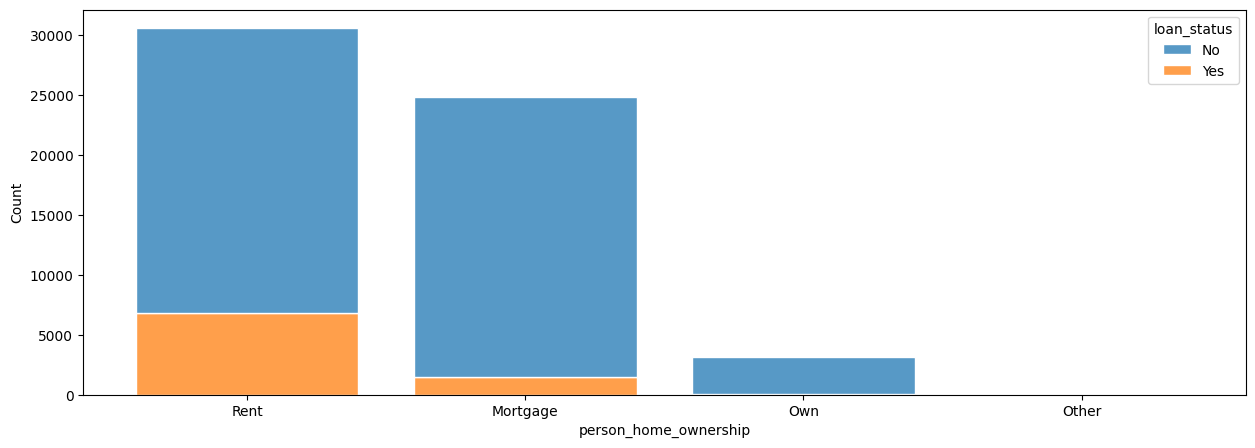

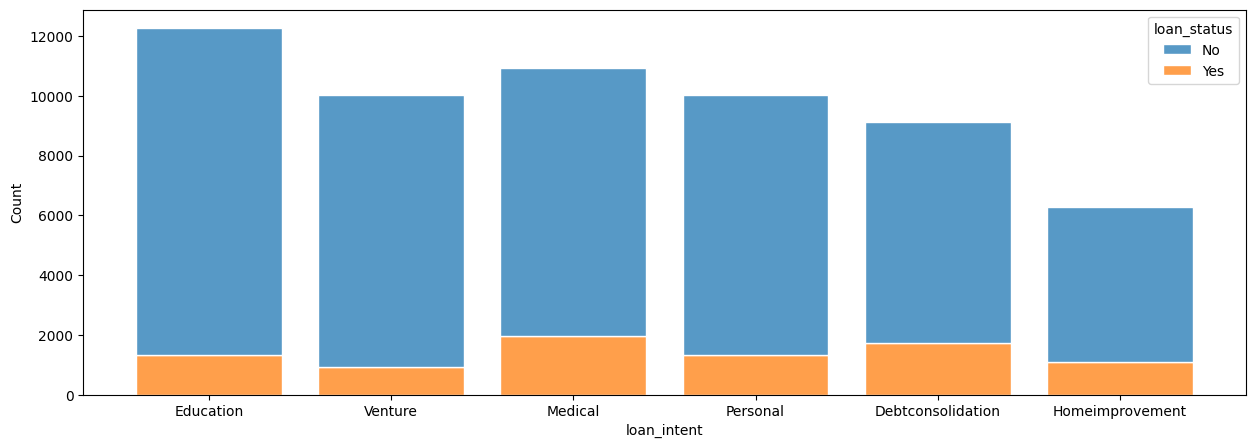

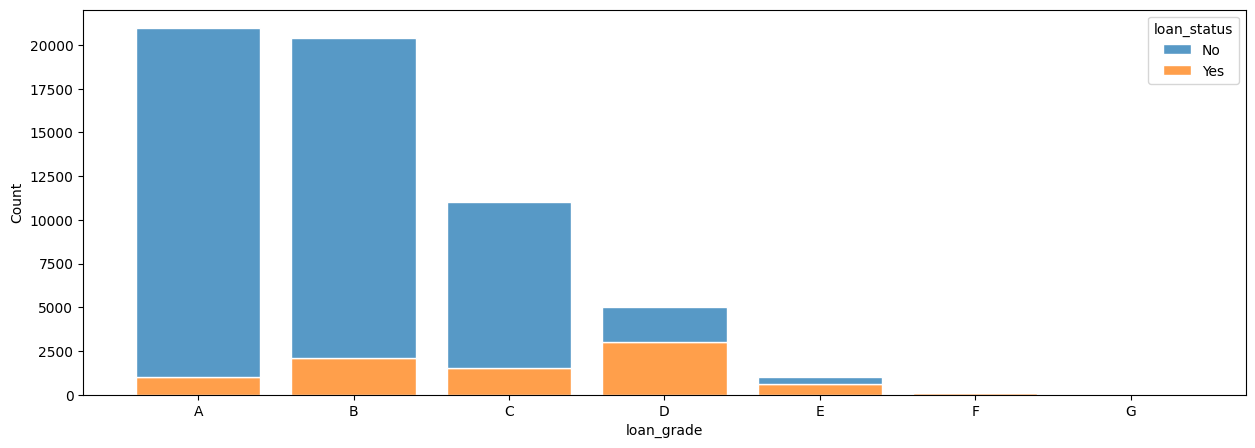

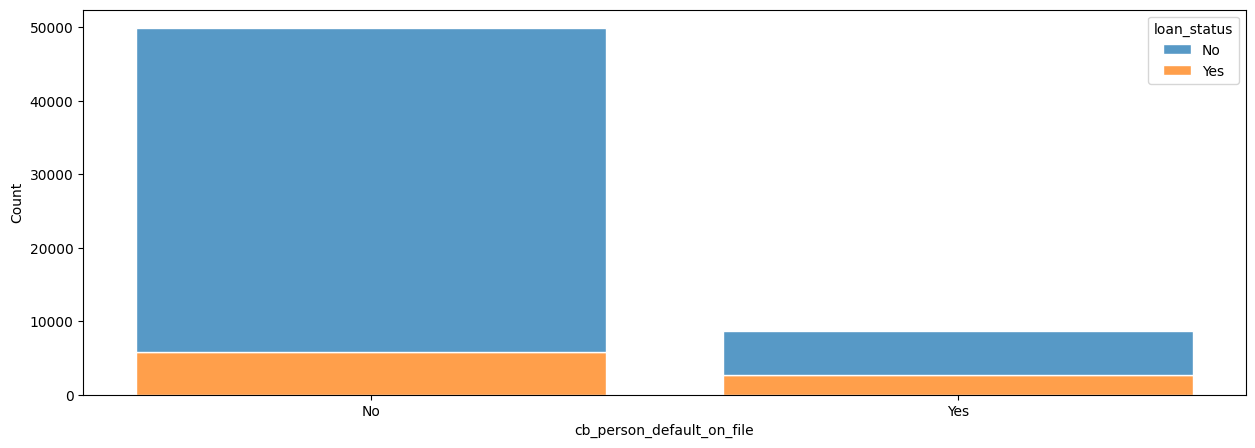

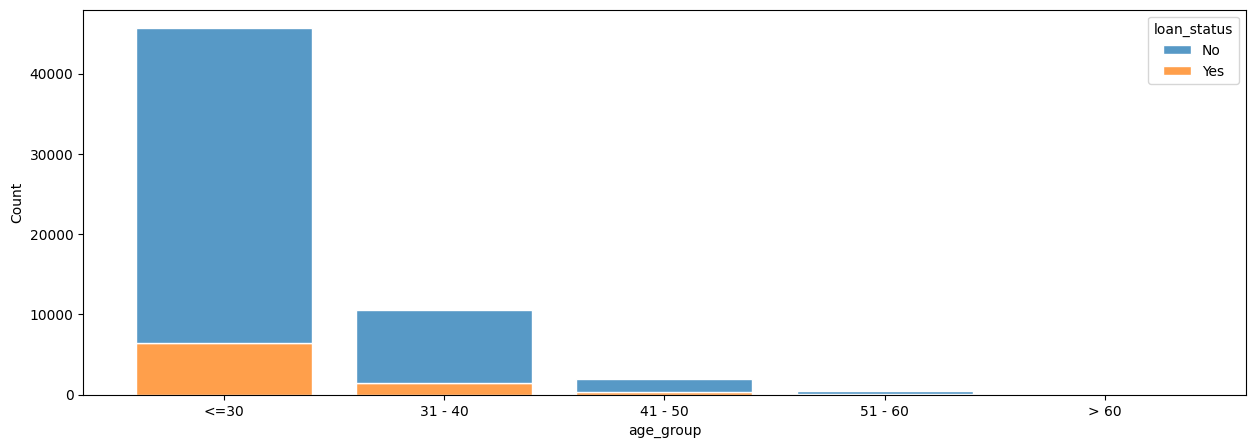

In [19]:
for col in categorical_var:
    if col != 'loan_status':
        plt.figure(figsize=(15,5,))
        sns.histplot(data=train_viz[[col,'loan_status']].value_counts().reset_index().sort_values('count', ascending=False),
                        x=col,
                        weights='count',
                        hue='loan_status',
                        multiple='stack',
                      #  palette=palette,
                        edgecolor='white',
                        shrink=0.8
                    );

In [20]:
train_subset

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000.0,RENT,0.0,EDUCATION,B,6000.0,11.49,0.17,N,14,0
1,22,56000.0,OWN,6.0,MEDICAL,C,4000.0,13.35,0.07,N,2,0
2,29,28800.0,OWN,8.0,PERSONAL,A,6000.0,8.90,0.21,N,10,0
3,30,70000.0,RENT,14.0,VENTURE,B,12000.0,11.11,0.17,N,5,0
4,22,60000.0,RENT,2.0,MEDICAL,A,6000.0,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
58640,34,120000.0,MORTGAGE,5.0,EDUCATION,D,25000.0,15.95,0.21,Y,10,0
58641,28,28800.0,RENT,0.0,MEDICAL,C,10000.0,12.73,0.35,N,8,1
58642,23,44000.0,RENT,7.0,EDUCATION,D,6800.0,16.00,0.15,N,2,1


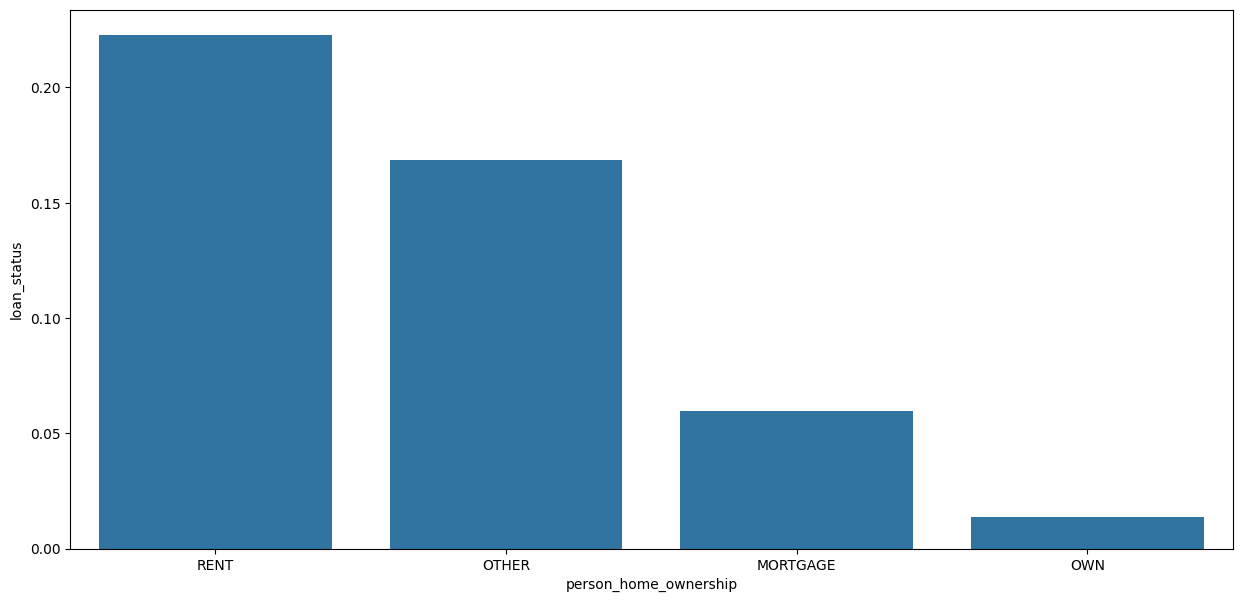

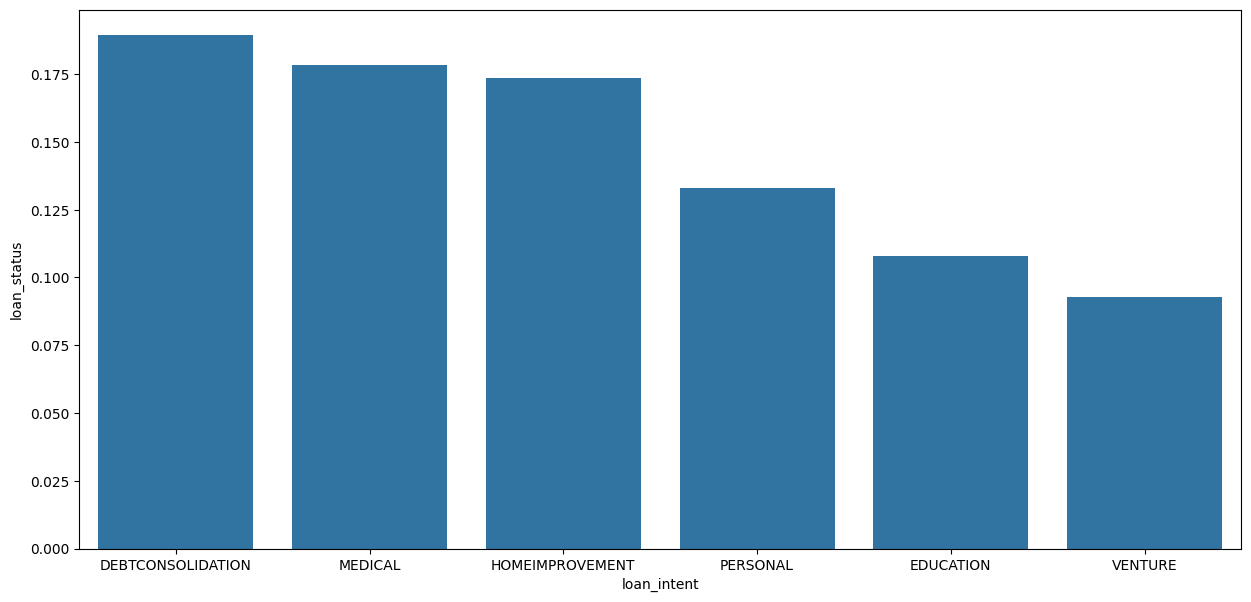

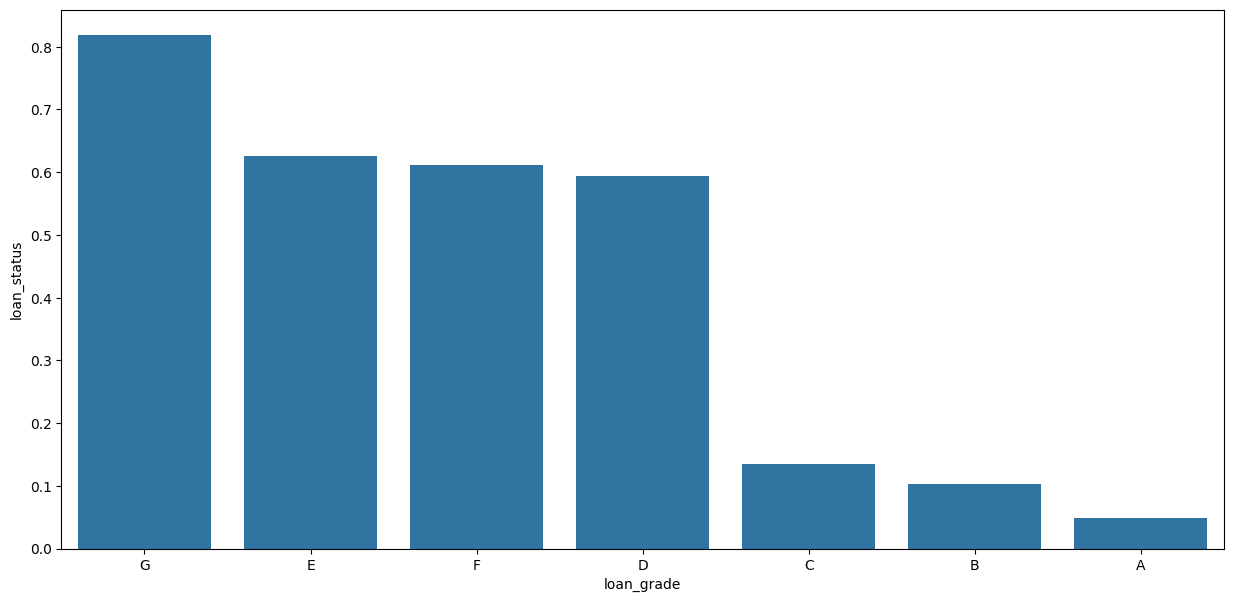

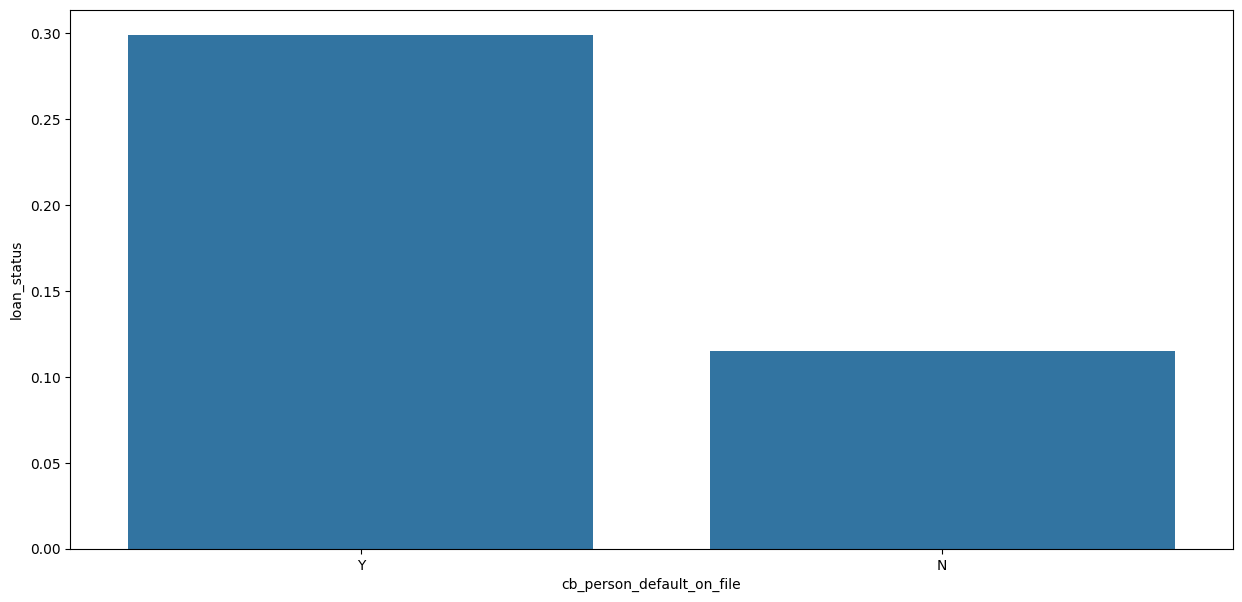

In [20]:
for col in categorical_var:
    if col not in ['age_group',' person_age', 'loan_status']:
        plt.figure(figsize=(15,7))
        sns.barplot(data = train_subset[[col, 'loan_status']].groupby(col).mean().reset_index().sort_values('loan_status', ascending=False),
                     x=col,
                     y = 'loan_status'
                   )
        plt.show()

### Distribution Continous Variables

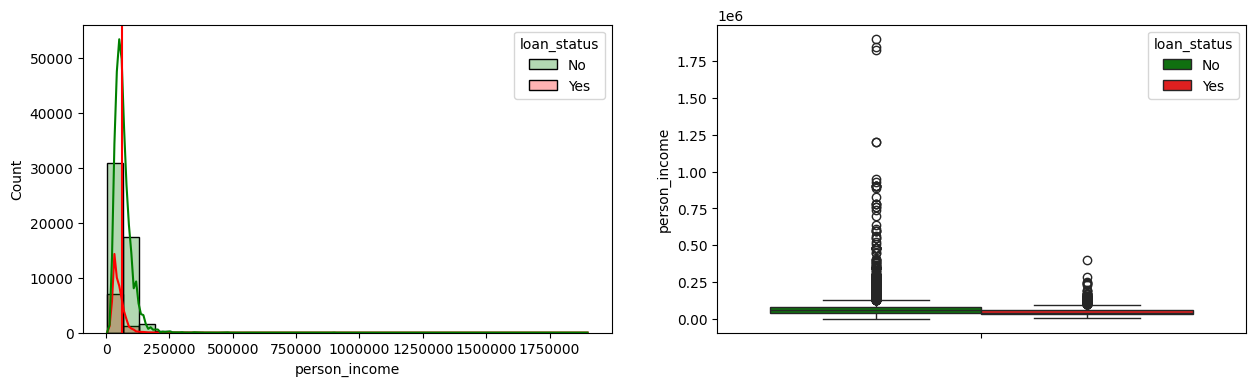

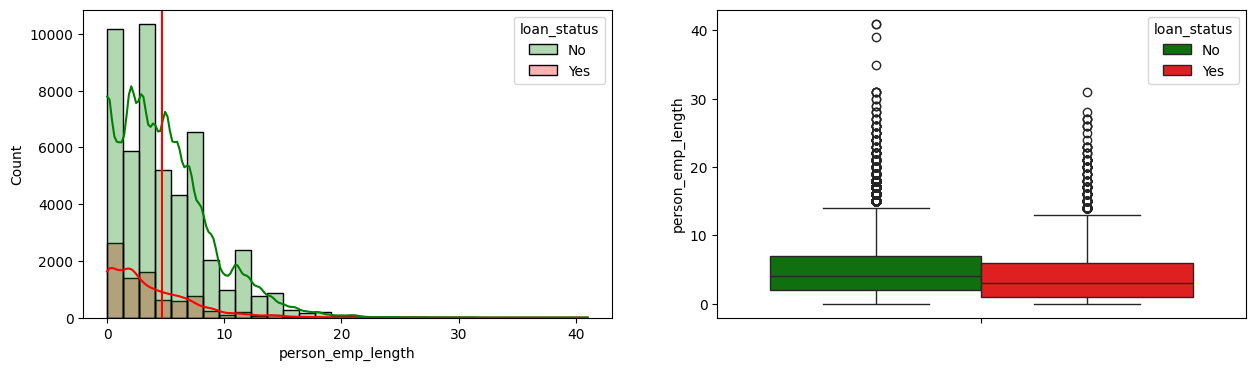

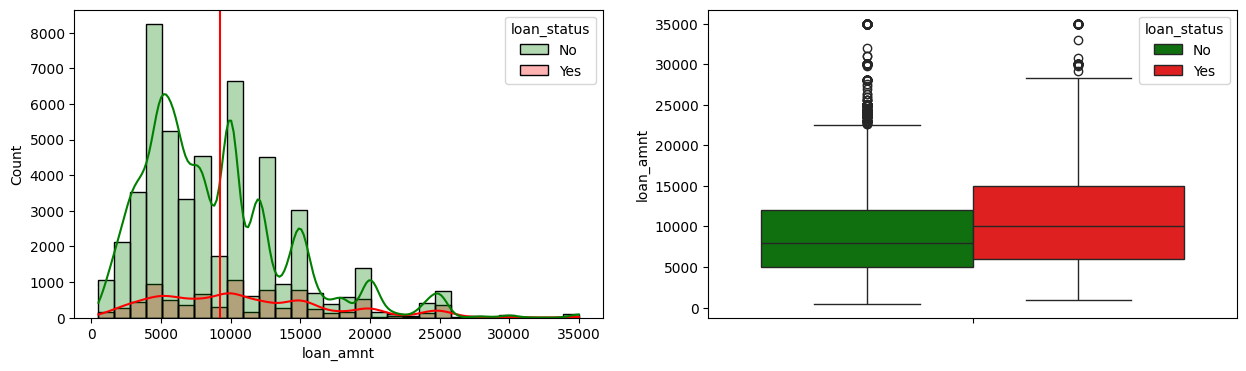

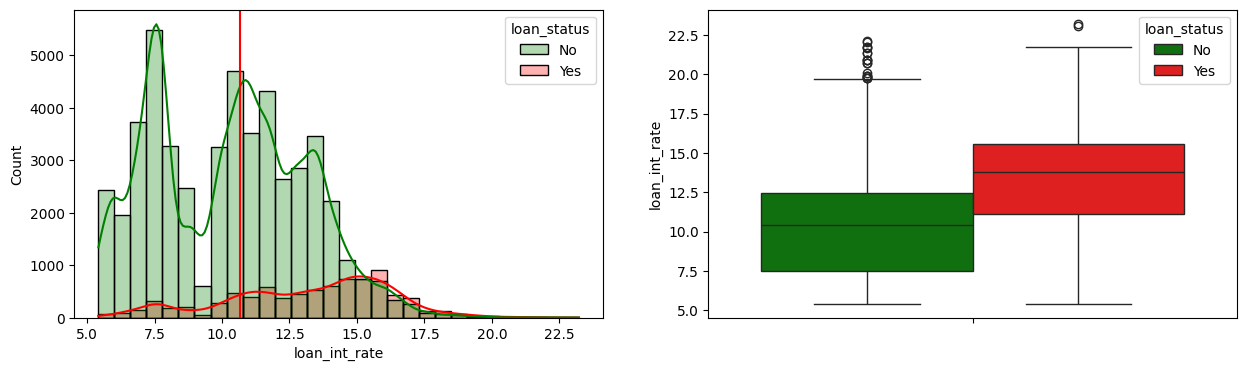

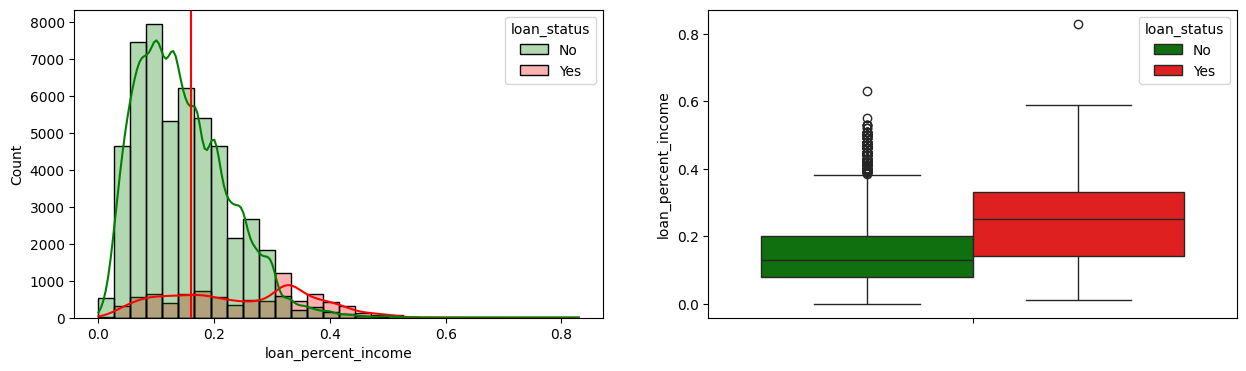

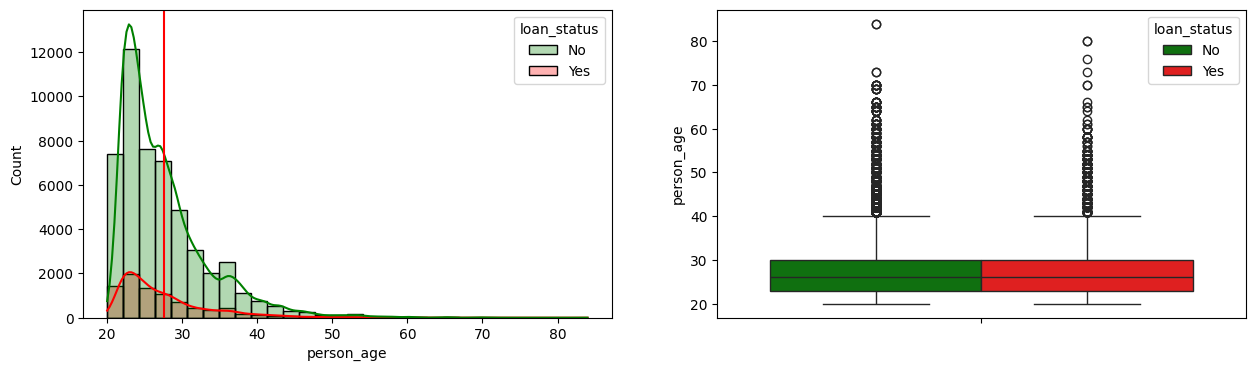

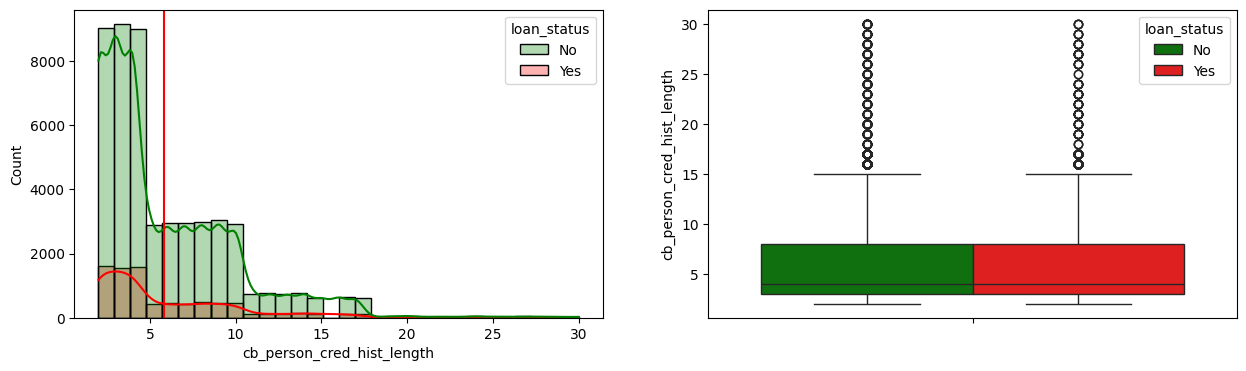

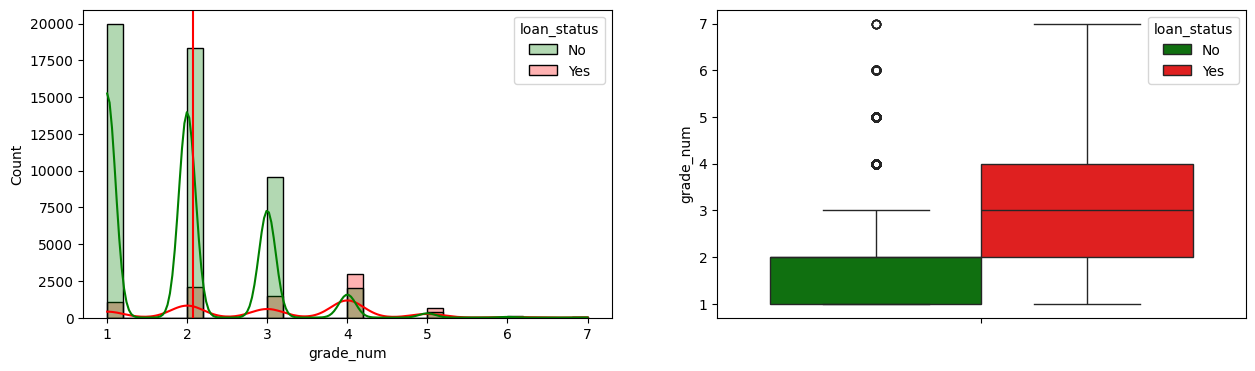

In [21]:
palette = ['green', 'red']

for num_var in continous_var+discrete_var:    

    fig, ax = plt.subplots(1, 2, figsize=(15, 4))   
    
    # Histograms    
    sns.histplot(data=train_viz, 
                      x=num_var,
                      bins = 30,
                      hue = 'loan_status',
                      palette=palette,
                      kde=True,
                      alpha=0.3,
                      ax=ax[0]                          
                ) 
    # Mean vertical line
    ax[0].axvline(np.mean(train_viz[num_var]), color="red")   
    ax[0].ticklabel_format(style='plain', axis='both')
    # Boxplots
    sns.boxplot(data=train_viz, 
                     y=num_var,
                     hue = 'loan_status',
                     palette=palette,
                     #showfliers=False,
                     ax=ax[1]
                   );

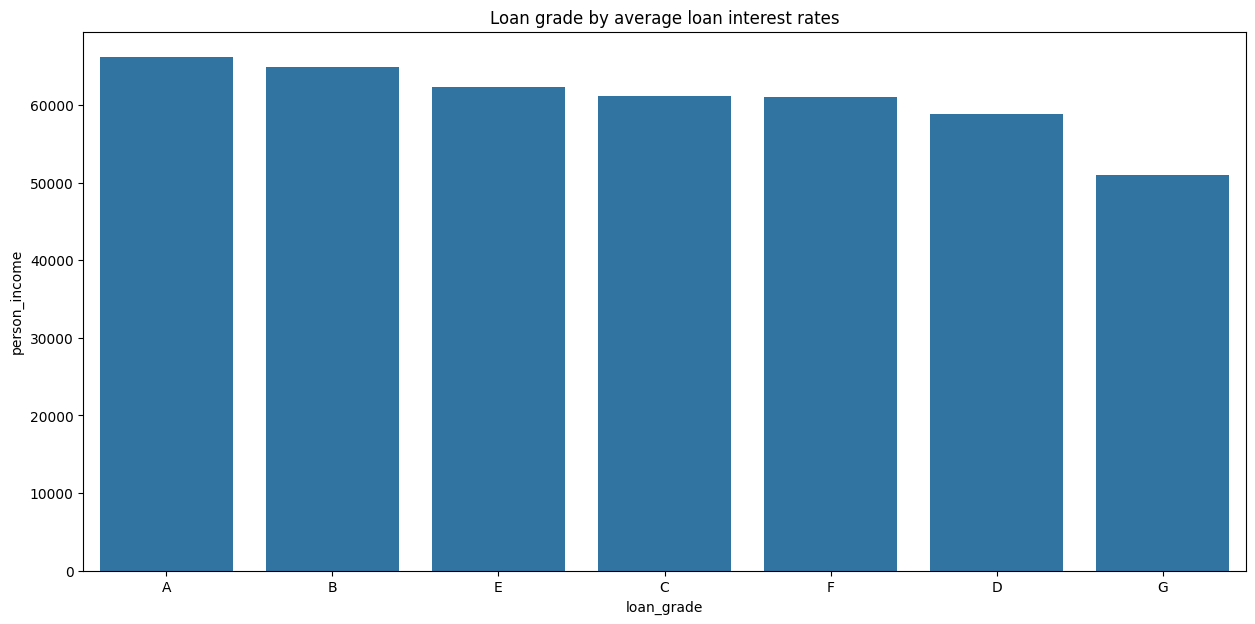

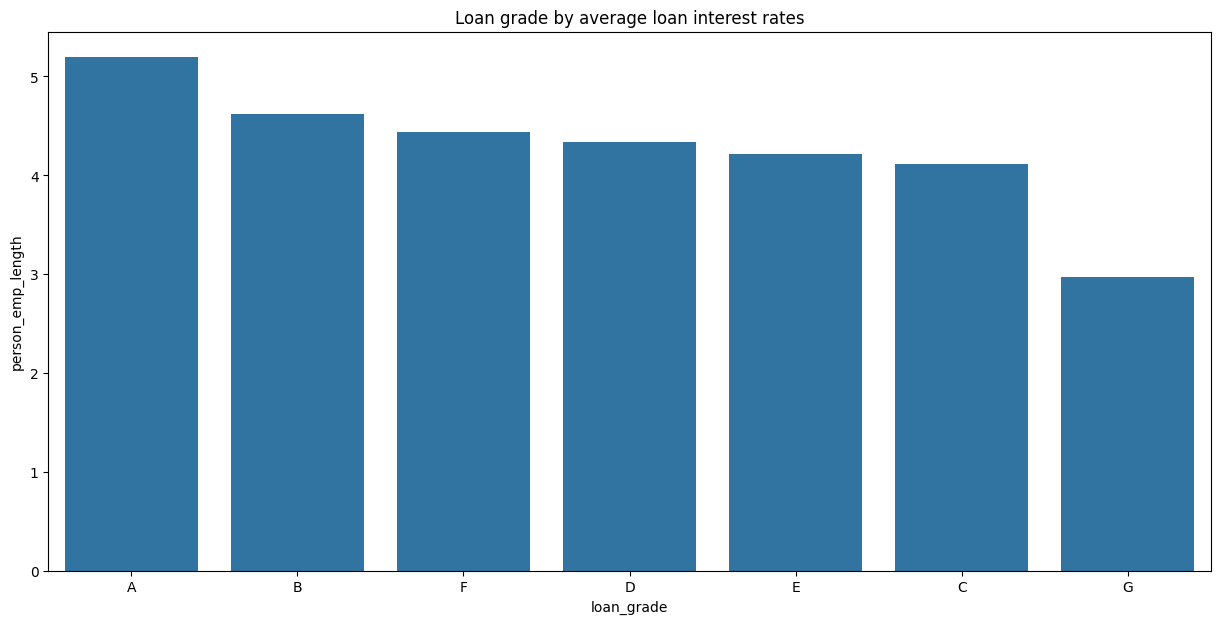

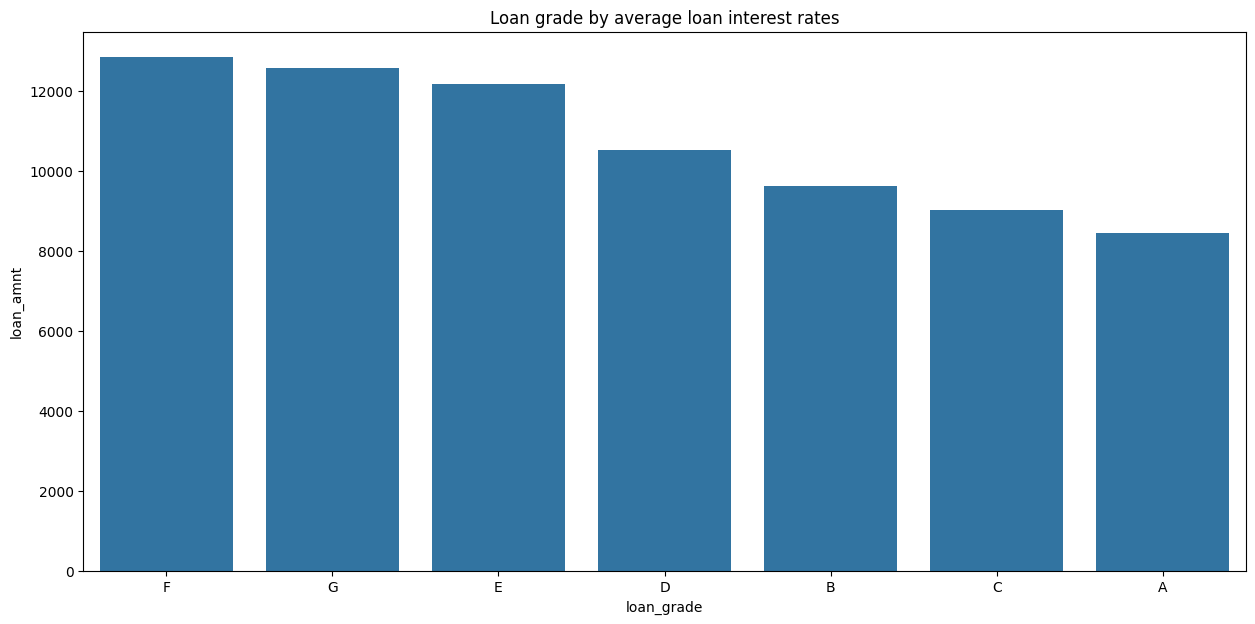

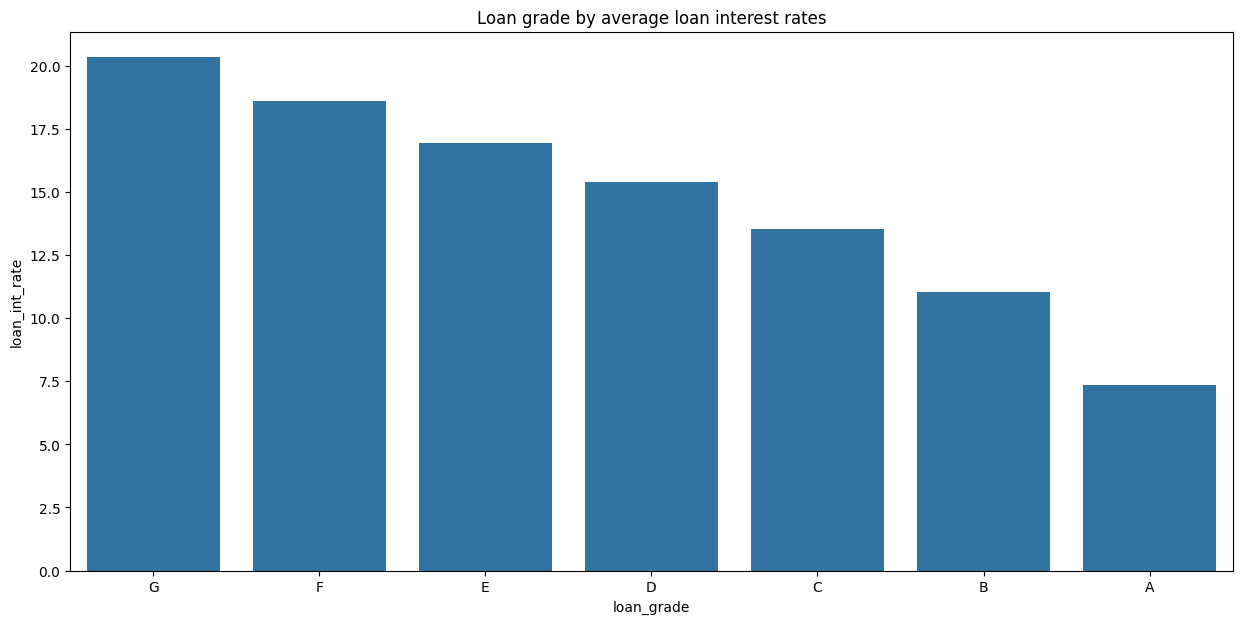

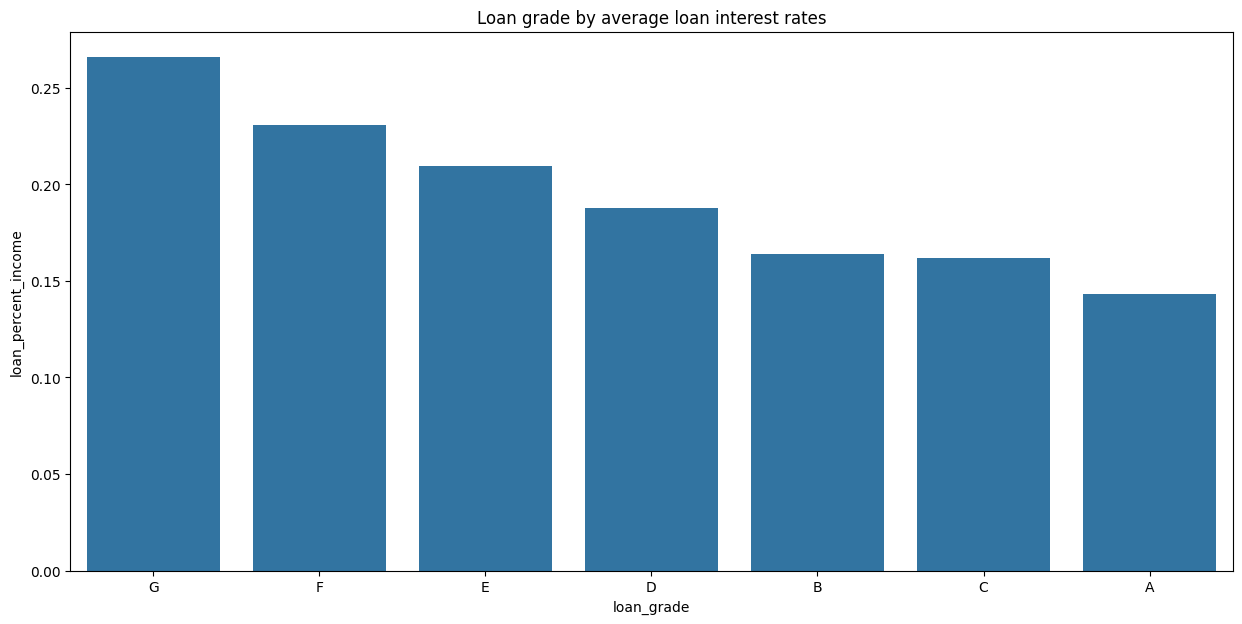

In [24]:
for col in continous_var:

    plt.figure(figsize=(15,7))

    sns.barplot(data=train_subset[[col, 'loan_grade']].groupby('loan_grade').mean().reset_index().sort_values(col, ascending=False),
                x='loan_grade',
                y=col
               )
    plt.title('Loan grade by average loan interest rates');

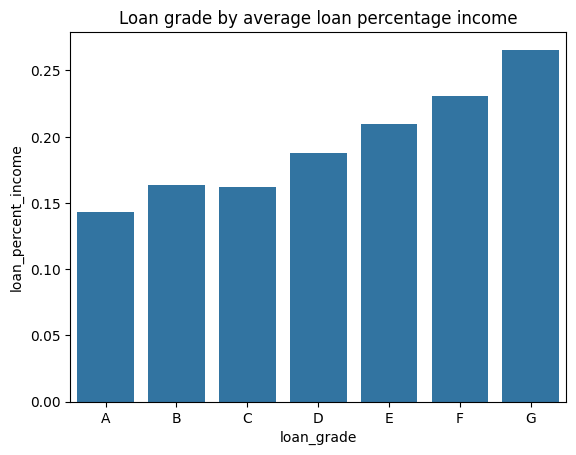

In [25]:
sns.barplot(data=train_subset[['loan_grade', 'loan_percent_income']].groupby('loan_grade').mean().reset_index(),
            x='loan_grade',
            y='loan_percent_income'
           )
plt.title('Loan grade by average loan percentage income');

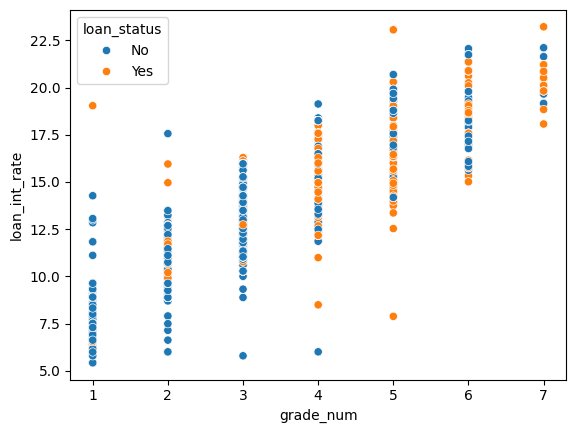

In [26]:
sns.scatterplot(data=train_viz,
                x = 'grade_num',
                y='loan_int_rate',
                hue='loan_status'
                );

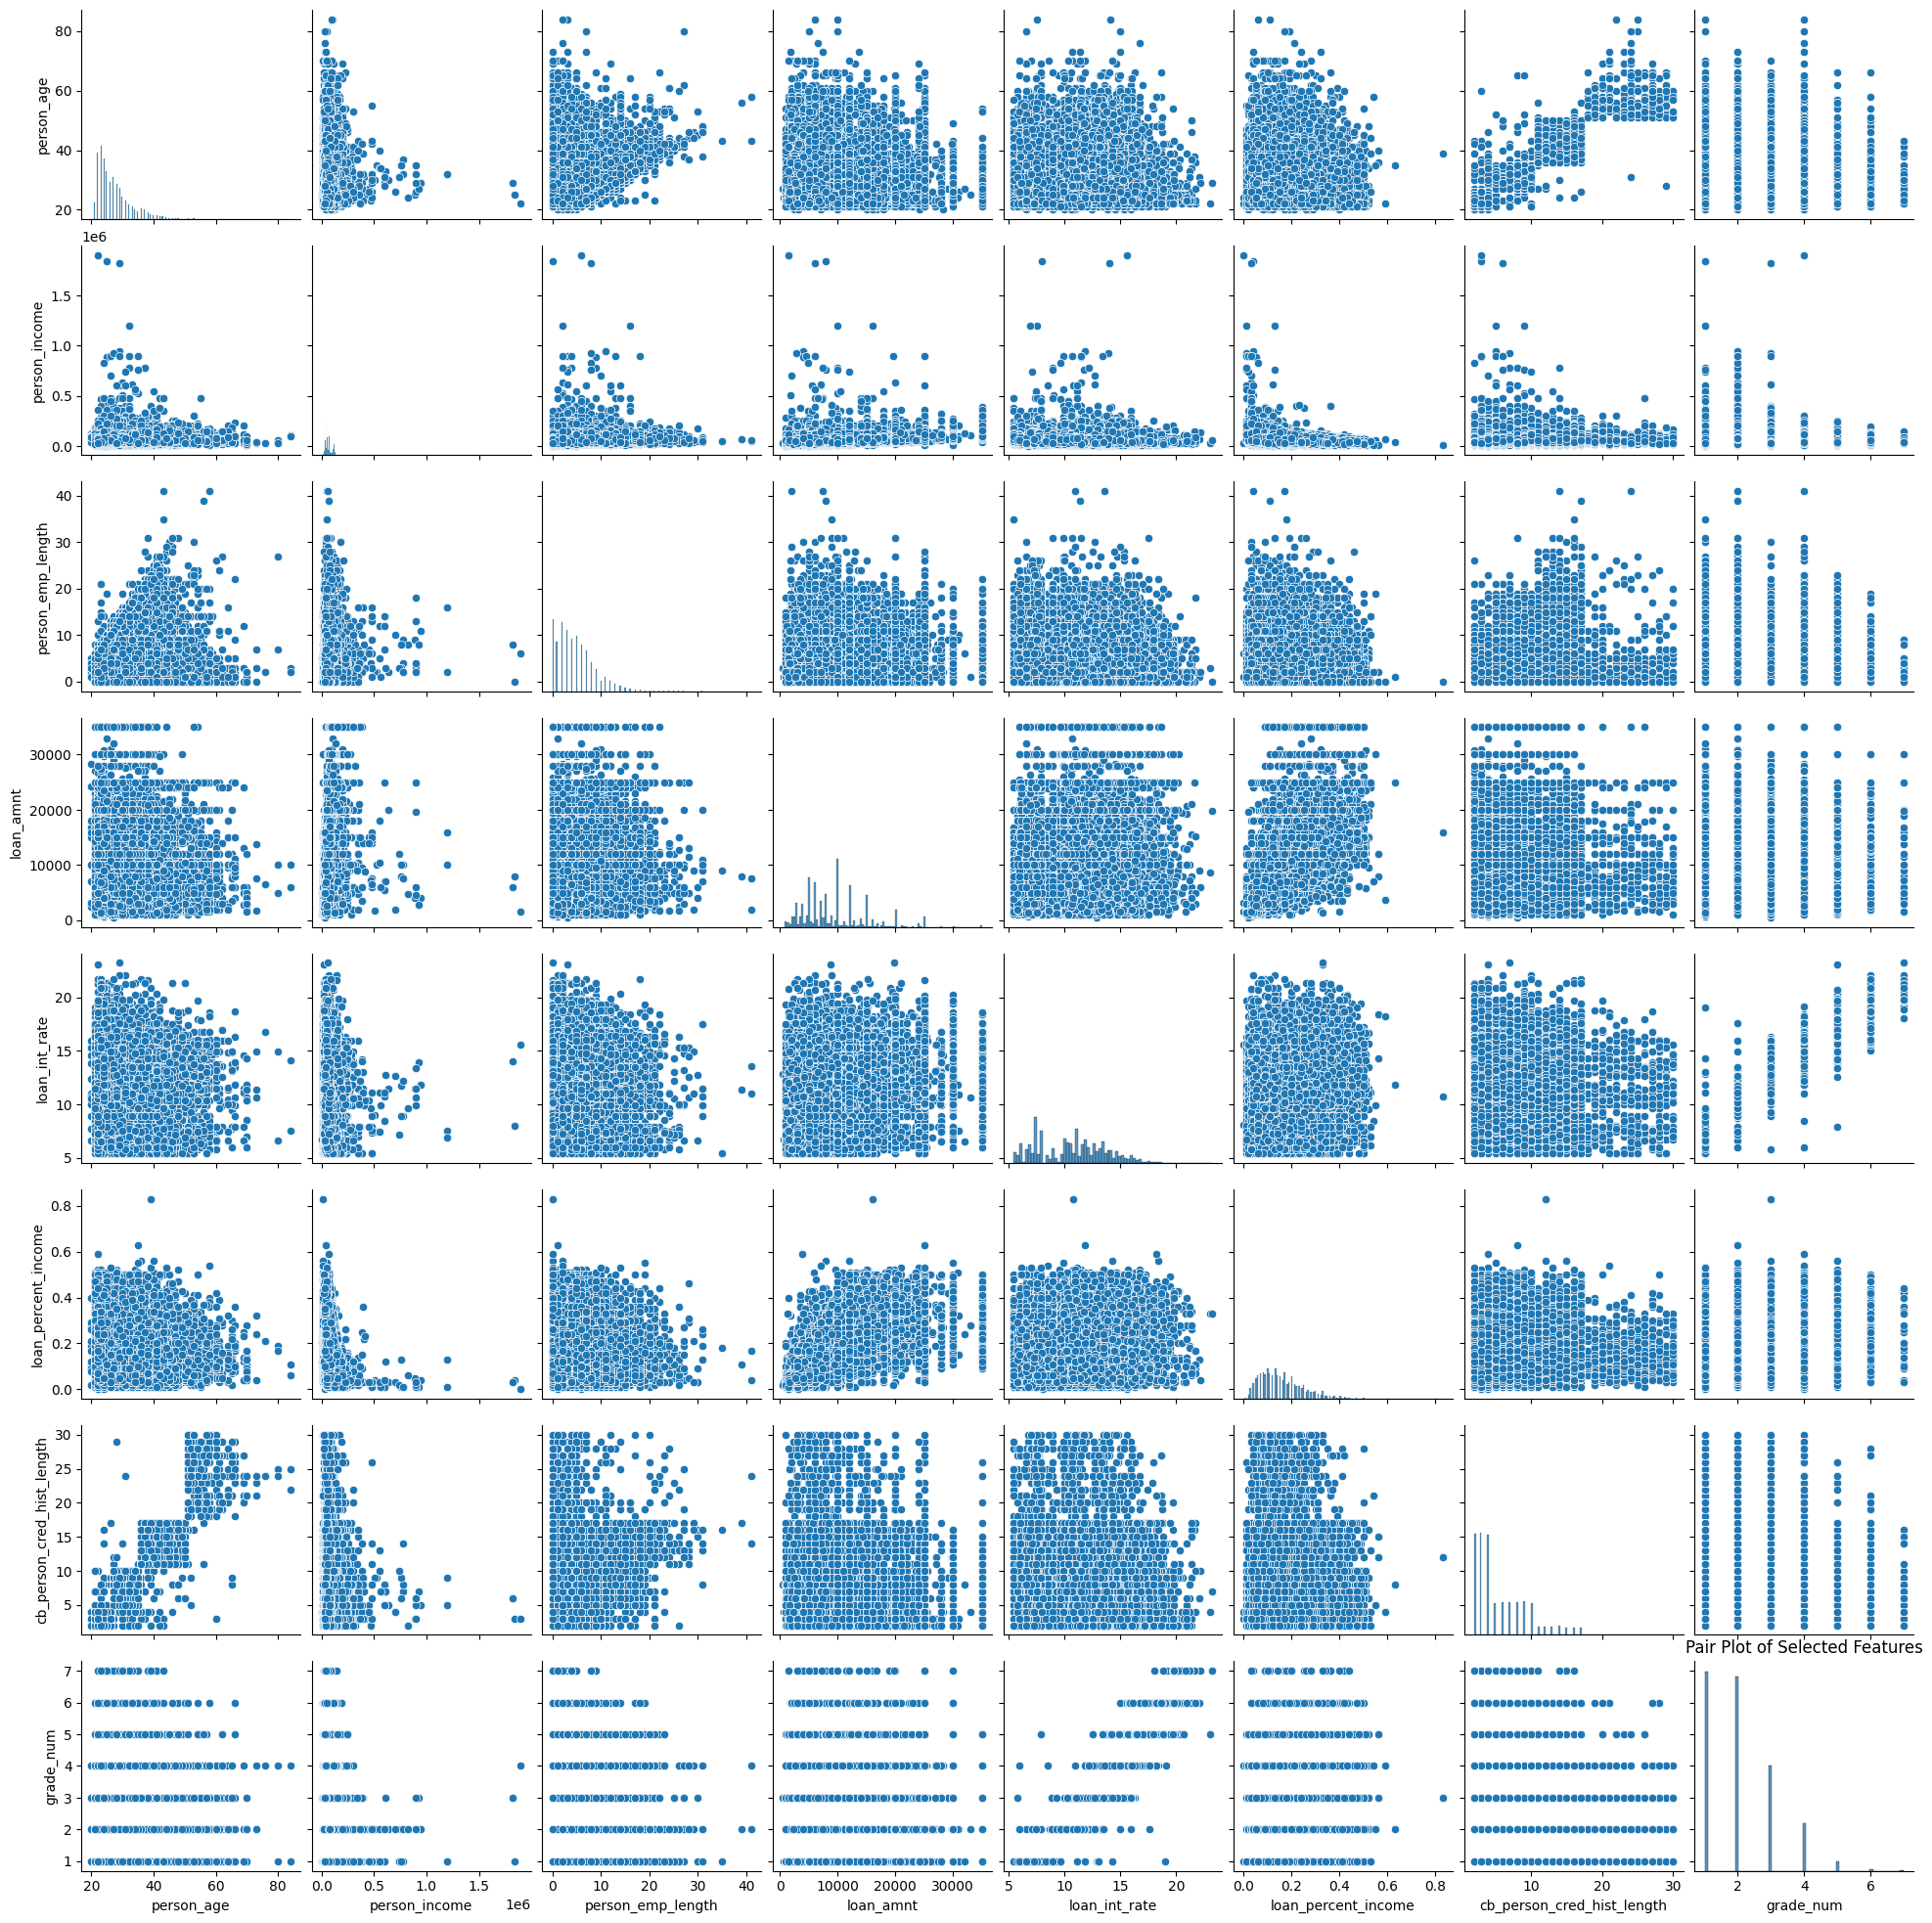

In [27]:
sns.pairplot(train_viz)
plt.title('Pair Plot of Selected Features')
plt.show()

# Feature Engineering

In [22]:
def ext_features(df):
    df['cb_person_cred_hist_length_ratio'] = df['cb_person_cred_hist_length']/df['person_age']
    df['financial_burden'] = df['loan_amnt'] * df['loan_int_rate']    
    df['loan_percent_income'] = df['loan_amnt']/df['person_income']
    return df

In [23]:
def enc_features(df):
    col_enc = ['person_home_ownership', 'loan_intent','cb_person_default_on_file']
    grade_num = {'A':1, 'B':2, 'C':3, 'D':4,'E':5,'F':6, 'G':7}

    
    for col in col_enc:
        df= pd.concat([df, pd.get_dummies(df[col], dtype=int, prefix=col,drop_first=True)], axis=1)
        df.drop(columns=col, inplace=True)
        
    df['loan_grade'] = df['loan_grade'].map(grade_num)

    return df

In [24]:
train_subset = ext_features(train_subset)
test = ext_features(test)

In [25]:
train_enc = enc_features(train_subset)
test_enc = enc_features(test)

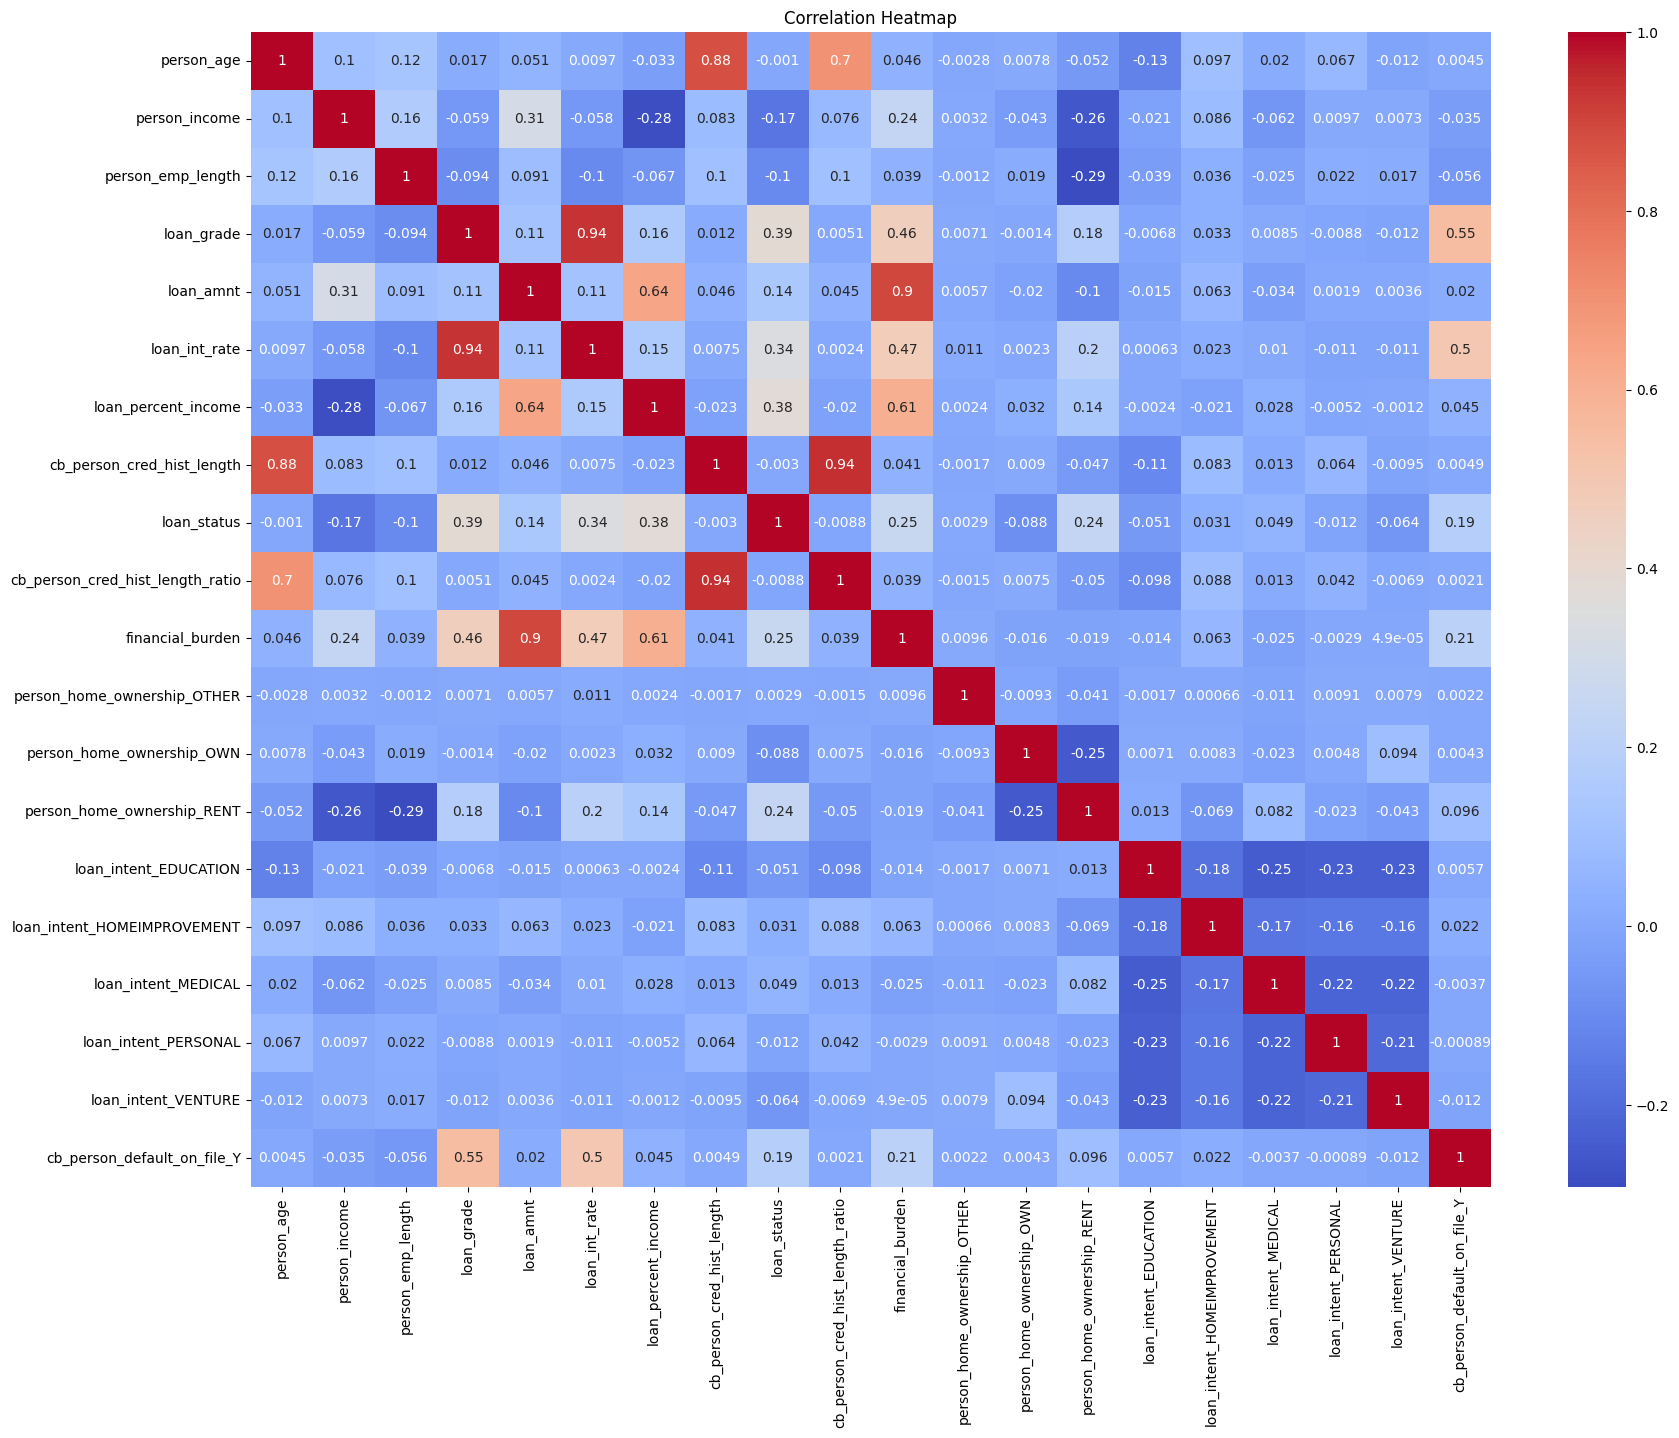

In [26]:
plt.figure(figsize=(20, 15))
sns.heatmap(pd.DataFrame(
                train_enc, 
                columns=train_enc.columns).corr(), 
                annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [31]:

X = train_enc.drop(columns='loan_status')

y = train_enc['loan_status']



# Oversample minority class using SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

# Random Forest AUC (0.989)

In [32]:
rf = RandomForestClassifier(random_state=42)

In [33]:
#rf_cv_params = {  'n_estimators' : [350, 360, 400], 
 #                 'max_depth' : [3, 4, 5],        
  #                'max_features': [5, 7, 10, 12],
   #               'min_samples_leaf' : [0.02, 0.035], 
    #              'min_samples_split' : [0.001,0.002],
     #             'max_samples' : [0.07, 0.08]
      #         }

In [34]:
#rf_cv = GridSearchCV(rf, 
 #                     rf_cv_params, 
  #                    refit='f1',                     
   #                   scoring='roc_auc',
    #                  n_jobs = -1)

In [35]:
#%%time

#rf_cv.fit(X_train, y_train)

In [36]:
rf_best_params = {'max_depth': 4,
                 'max_features': 5,
                 'max_samples': 0.07,
                 'min_samples_leaf': 0.02,
                 'min_samples_split': 0.001,
                 'n_estimators': 400}

In [37]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
y_pred = rf.predict(X_test)

In [39]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay,\
precision_recall_curve, roc_auc_score, roc_curve

print(f'Accuracy: {accuracy_score(y_pred, y_test)}')

print(f'Precision: {precision_score(y_pred, y_test)}')

print(f'Recall: {recall_score(y_pred, y_test)}')

Accuracy: 0.954070981210856
Precision: 0.9414217633042097
Recall: 0.9659739201303994


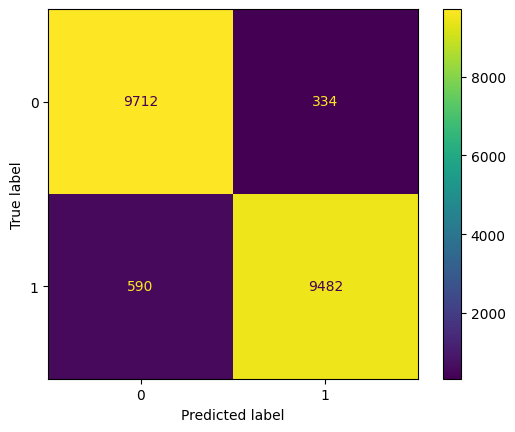

In [40]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

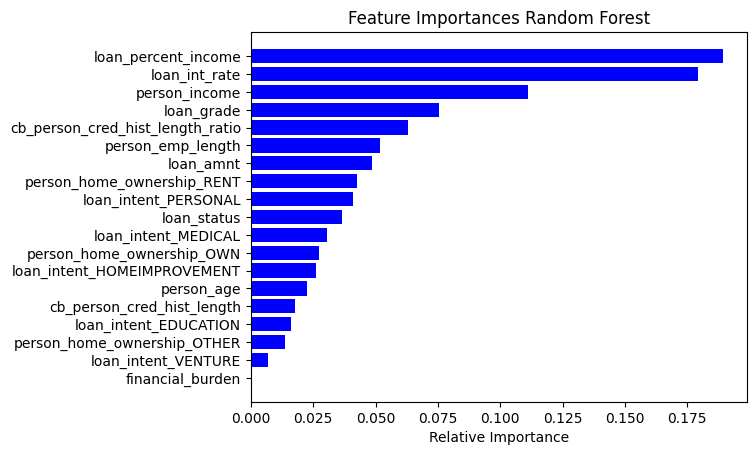

In [41]:
importances = rf.feature_importances_
indices = np.argsort(importances)
features=train_enc.columns

plt.title('Feature Importances Random Forest')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

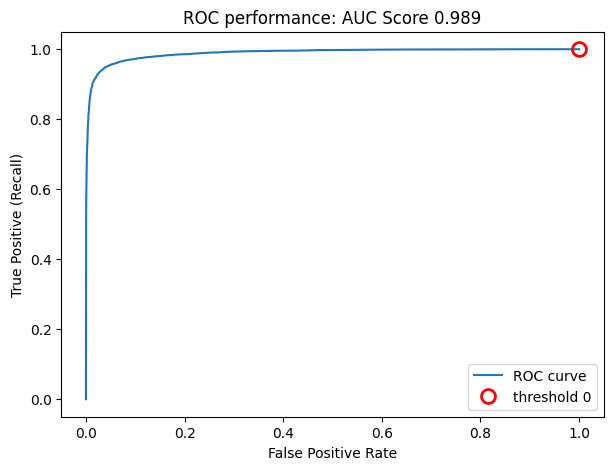

In [42]:
# probability results
proba_ = rf.predict_proba(X_test)[:, 1]

# eval metrics
precision, recall, thresholds = precision_recall_curve(y_test, proba_)
fp, tp, thresholds_roc = roc_curve(y_test, proba_)

auc_score = np.round(roc_auc_score(y_test, proba_), 4)    

close_default = np.argmin(np.abs(thresholds - 0.5))
close_zero = np.argmin(np.abs(thresholds_roc))

# Plot ROC Curve
plt.figure(figsize=(7, 5))

plt.plot(fp, tp, label="ROC curve")
plt.plot(fp[close_zero], 
         tp[close_zero], 'o', 
         c='r', markersize=10, 
         label='threshold 0', 
         fillstyle="none", mew=2)
plt.title(f"ROC performance: AUC Score {auc_score}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive (Recall)")
plt.legend(loc='best')   

plt.show()   

# XGBoost AUC - (0.991)

In [48]:
xgb = xgb.XGBClassifier()

In [49]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [50]:
y_pred = xgb.predict(X_test)

In [51]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay,\
precision_recall_curve, roc_auc_score, roc_curve

print(f'Accuracy: {accuracy_score(y_pred, y_test)}')

print(f'Precision: {precision_score(y_pred, y_test)}')

print(f'Recall: {recall_score(y_pred, y_test)}')

Accuracy: 0.966447957053385
Precision: 0.954328832406672
Recall: 0.9781215019843289


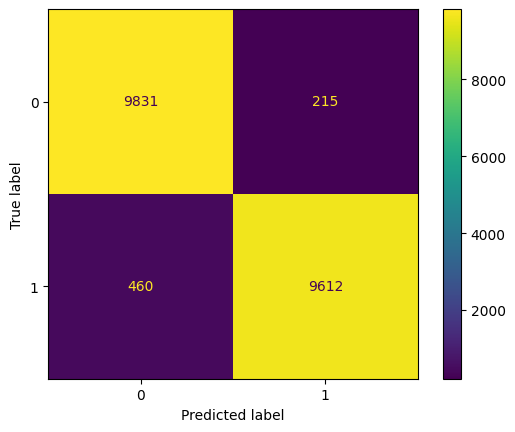

In [52]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

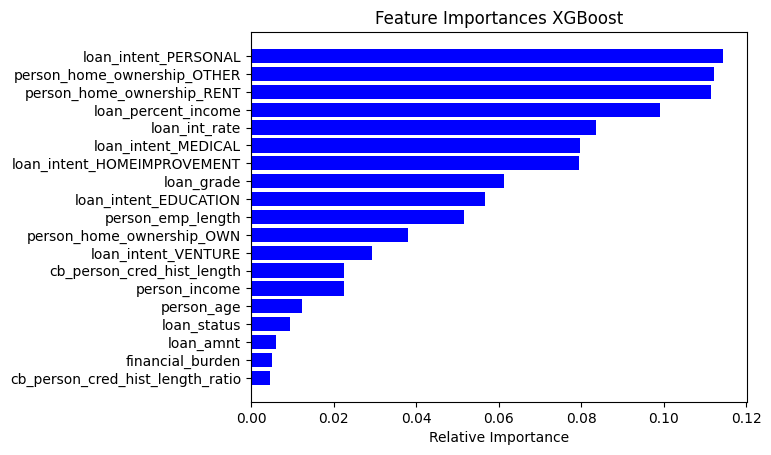

In [54]:
importances = xgb.feature_importances_
indices = np.argsort(importances)
features=train_enc.columns

plt.title('Feature Importances XGBoost')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

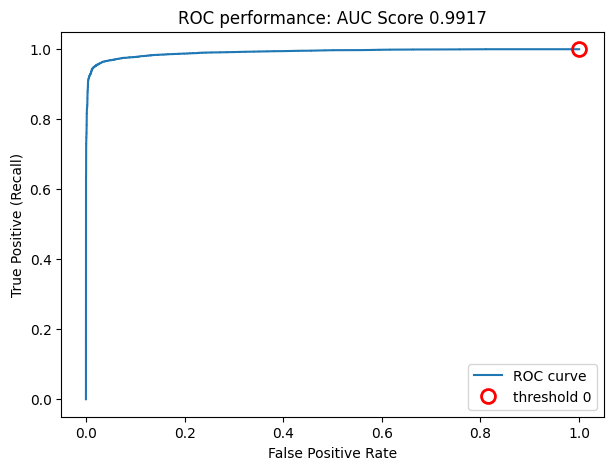

In [55]:
# probability results
proba_ = xgb.predict_proba(X_test)[:, 1]

# eval metrics
precision, recall, thresholds = precision_recall_curve(y_test, proba_)
fp, tp, thresholds_roc = roc_curve(y_test, proba_)

auc_score = np.round(roc_auc_score(y_test, proba_), 4)    

close_default = np.argmin(np.abs(thresholds - 0.5))
close_zero = np.argmin(np.abs(thresholds_roc))

# Plot ROC Curve
plt.figure(figsize=(7, 5))

plt.plot(fp, tp, label="ROC curve")
plt.plot(fp[close_zero], 
         tp[close_zero], 'o', 
         c='r', markersize=10, 
         label='threshold 0', 
         fillstyle="none", mew=2)
plt.title(f"ROC performance: AUC Score {auc_score}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive (Recall)")
plt.legend(loc='best')   

plt.show()   

# Submission:

In [56]:
predictions = xgb.predict_proba(test_enc)

In [57]:
submission_df = pd.DataFrame({
    'id': test_enc.index,
    'loan_status': predictions[:,1]
})

In [59]:
submission_df.head()

,id,loan_status
0,58645,0.999370
1,58646,0.006386
2,58647,0.128387
3,58648,0.036412
4,58649,0.076641


In [58]:
submission_df.to_csv('submission.csv', index=False)

print("Predictions saved to submission.csv")

Predictions saved to submission.csv




<center><img src="https://cdn.prod.website-files.com/646218c67da47160c64a84d5/64634be786d11debe86c8c42_86.png" width=200 height=200 /></center>